In [1]:
import sys
from pathlib import Path

#Find root directory
root_dir = Path().absolute()
if root_dir.parts[-2:] == ('notebooks', 'algae_bloom'):
    root_dir = Path(*root_dir.parts[:-2])
root_dir = str(root_dir)

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Root dir: /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-project
Added the following directory to the PYTHONPATH: /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-project


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🌐 Imports

In [2]:
import os
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
#from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor #
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## 🌳 Connect to Hopsworks and get variables from Hopsworks secret </span>

In [3]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

#Get the dictionary with all batch locations
bath_locations_json = secrets.get_secret("BATH_LOCATIONS_JSON").value
bath_locations = json.loads(bath_locations_json)
print(bath_locations)

2025-12-29 00:11:09,994 INFO: Initializing external client
2025-12-29 00:11:09,994 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-12-29 00:11:11,704 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286295
[{'bath_location': 'Bergabadet', 'latitude': 59.057008, 'longitude': 17.440774}, {'bath_location': 'Bränningestrand', 'latitude': 59.148617, 'longitude': 17.6674}, {'bath_location': 'Eklundsnäsbadet', 'latitude': 59.16883, 'longitude': 17.59184}, {'bath_location': 'Farstanäsbadet', 'latitude': 59.096884, 'longitude': 17.65387}, {'bath_location': 'Mälarbadet', 'latitude': 59.222657, 'longitude': 17.611886}, {'bath_location': 'Nya Malmsjöbadet', 'latitude': 59.234823, 'longitude': 17.536534}, {'bath_location': 'Näsets udde(Glashyttan)', 'latitude': 59.158419, 'longitude': 17.66072}, {'bath_location': 'Underåsbadet', 'latitude': 59.26482, 'longitude': 17.536534}, {'bath_location': 'Åbynäsbadet', 'latitude': 59.018397, 'longitude': 17.619576}]


## 🌾 Get feature groups

In [4]:
#Select version of feature group
wt_version = 1
w_version = 1

#Retrieve feature groups
water_temperature_fg = fs.get_feature_group( 
    name='water_temperature',
    version=wt_version,
)

weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)

## 👀 Create feature view

In [5]:
# Select features for training data from both feature groups
from hsfs.feature import Feature

selected_features = water_temperature_fg.select(['temp_water', 'alias', 'formatted_time','lagged_wt_1_day', 'lagged_wt_2_days', 'lagged_wt_3_days']).join(weather_fg.select(['temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'shortwave_radiation_sum_yday', 'sunshine_duration_yday']), on=['alias'])

In [6]:
#Select version of feature group
fv_version = 1

#Create feature view

feature_view = fs.get_or_create_feature_view(
        name='water_temperature_fv',
        description="weather features with water teamperature as the target",
        version=fv_version,
        labels=['temp_water'],
        query=selected_features,

    )

## 🧩 Create train and test datasets

In [7]:
start_date_test_data = "2025-01-01" #<-- KOLLA OM VI VILL ÄNDRA

# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
#Split test and train data
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.64s) 


,alias,formatted_time,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,shortwave_radiation_sum_yday,sunshine_duration_yday
0,Åbynäsbadet,2022-01-04 11:35:00+00:00,2.4,1.8,2.1,0.85,0.0,15.188416,238.570480,1.530000,4.242111
1,Åbynäsbadet,2022-01-05 11:35:00+00:00,2.1,2.4,1.8,0.45,0.0,8.854829,296.564972,0.600000,0.315473
2,Åbynäsbadet,2022-01-06 11:36:00+00:00,2.7,2.1,2.4,-4.65,0.0,12.783802,302.347412,1.670000,4.362058
3,Åbynäsbadet,2022-01-07 11:36:00+00:00,2.5,2.7,2.1,-5.15,0.0,4.896529,72.897186,1.090000,2.279378
4,Åbynäsbadet,2022-01-08 11:37:00+00:00,2.3,2.5,2.7,0.30,0.0,4.104631,232.124954,0.890000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
7383,Bergabadet,2024-08-02 14:25:00+00:00,22.2,21.9,22.8,20.35,0.0,9.693296,328.671356,19.530001,11.821480
7384,Bergabadet,2024-08-03 14:25:00+00:00,22.3,22.2,21.9,22.85,0.0,8.669949,318.366547,21.160000,14.736062
7385,Bergabadet,2024-08-04 14:25:00+00:00,22.9,22.3,22.2,20.00,0.1,2.811690,140.194473,14.770000,10.797956
7386,Bergabadet,2024-08-05 14:25:00+00:00,21.4,22.9,22.3,22.65,0.0,6.162207,353.290253,19.670000,14.174074


In [9]:
#Handle categorical features, converts into numerical values for XGBoost
# if running_a:
#     categorical_transformer=Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])
#     preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, ['street'])], remainder="passthrough")


In [10]:
#Double check
# if running_a:
#     X_train = data_sets[locations[0]['street']][0]
# X_train

In [9]:
BATH_TO_CODE = {"Bergabadet":0,"Bränningestrand":1,"Eklundsnäsbadet":2,"Farstanäsbadet":3, "Mälarbadet":4, "Nya Malmsjöbadet":5, "Näsets udde(Glashyttan)":6, "Underåsbadet":7, "Åbynäsbadet":8}
CODE_TO_BATH = {0:"Bergabadet", 1:"Bränningestrand", 2:"Eklundsnäsbadet", 3:"Farstanäsbadet", 4:"Mälarbadet", 5:"Nya Malmsjöbadet", 6:"Näsets udde(Glashyttan)", 7:"Underåsbadet", 8:"Åbynäsbadet"}

#Drop formatted_time since this will not be feature for training
X_features = X_train.drop(columns=['formatted_time'])
X_test_features = X_test.drop(columns=['formatted_time'])  
#Model-dependent transformation to create categorical feature from alias
#X_features['alias'] = X_train['alias'].astype('category').cat.codes
#X_test_features['alias'] = X_test['alias'].astype('category').cat.codes
X_features["alias"] = X_features["alias"].map(BATH_TO_CODE)
X_test_features["alias"] = X_test_features["alias"].map(BATH_TO_CODE)

X_features

,alias,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,shortwave_radiation_sum_yday,sunshine_duration_yday
0,8,2.4,1.8,2.1,0.85,0.0,15.188416,238.570480,1.530000,4.242111
1,8,2.1,2.4,1.8,0.45,0.0,8.854829,296.564972,0.600000,0.315473
2,8,2.7,2.1,2.4,-4.65,0.0,12.783802,302.347412,1.670000,4.362058
3,8,2.5,2.7,2.1,-5.15,0.0,4.896529,72.897186,1.090000,2.279378
4,8,2.3,2.5,2.7,0.30,0.0,4.104631,232.124954,0.890000,0.000000
...,...,...,...,...,...,...,...,...,...,...
7383,0,22.2,21.9,22.8,20.35,0.0,9.693296,328.671356,19.530001,11.821480
7384,0,22.3,22.2,21.9,22.85,0.0,8.669949,318.366547,21.160000,14.736062
7385,0,22.9,22.3,22.2,20.00,0.1,2.811690,140.194473,14.770000,10.797956
7386,0,21.4,22.9,22.3,22.65,0.0,6.162207,353.290253,19.670000,14.174074


In [10]:
#Check y_train
y_train

,temp_water
0,2.1
1,2.7
2,2.5
3,2.3
4,2.0
...,...
7383,22.3
7384,22.9
7385,21.4
7386,23.1


---

## 🏋️‍♀️ Train model

In [11]:
# Creating an instance of the XGBoost Regressor
#xgb_regressor = XGBRegressor()
cat_regressor = CatBoostRegressor(loss_function="RMSE")

# Fitting the Regressor to the training data
#xgb_regressor.fit(X_features, y_train)
cat_regressor.fit(X_features, y_train)

Learning rate set to 0.055046
0:	learn: 7.0750671	total: 71.9ms	remaining: 1m 11s
1:	learn: 6.7065005	total: 72.6ms	remaining: 36.2s
2:	learn: 6.3561179	total: 73.4ms	remaining: 24.4s
3:	learn: 6.0353460	total: 74.1ms	remaining: 18.4s
4:	learn: 5.7192816	total: 74.8ms	remaining: 14.9s
5:	learn: 5.4260145	total: 75.6ms	remaining: 12.5s
6:	learn: 5.1486473	total: 76.3ms	remaining: 10.8s
7:	learn: 4.8892604	total: 77ms	remaining: 9.55s
8:	learn: 4.6432510	total: 77.7ms	remaining: 8.56s
9:	learn: 4.4089228	total: 78.5ms	remaining: 7.77s
10:	learn: 4.1871048	total: 79.2ms	remaining: 7.12s
11:	learn: 3.9821792	total: 79.9ms	remaining: 6.58s
12:	learn: 3.7851937	total: 80.5ms	remaining: 6.11s
13:	learn: 3.6035520	total: 81.3ms	remaining: 5.73s
14:	learn: 3.4295826	total: 82ms	remaining: 5.38s
15:	learn: 3.2620967	total: 82.6ms	remaining: 5.08s
16:	learn: 3.1008023	total: 83.3ms	remaining: 4.82s
17:	learn: 2.9559148	total: 83.9ms	remaining: 4.58s
18:	learn: 2.8146692	total: 84.7ms	remaining: 4

In [12]:
# Predicting target values on the test set
#y_pred = xgb_regressor.predict(X_test_features)
y_pred = cat_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 0.5229886938636704
R squared: 0.9889272839446714


In [13]:
#Adding the predictions to the dataframe
df = y_test
df['predicted_temp_water'] = y_pred
df['predicted_temp_water'] = df['predicted_temp_water'].astype(np.float32)

In [14]:
#Adding the time and name of bath location to dataframe again and sort by that, for plot
df['formatted_time'] = X_test['formatted_time']
df['alias'] = X_test['alias']
df = df.sort_values(by=['formatted_time'])

In [15]:
# Creating a directory for the model artifacts if it doesn't exist

model_dir = "water_temperature_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)
   


Bergabadet


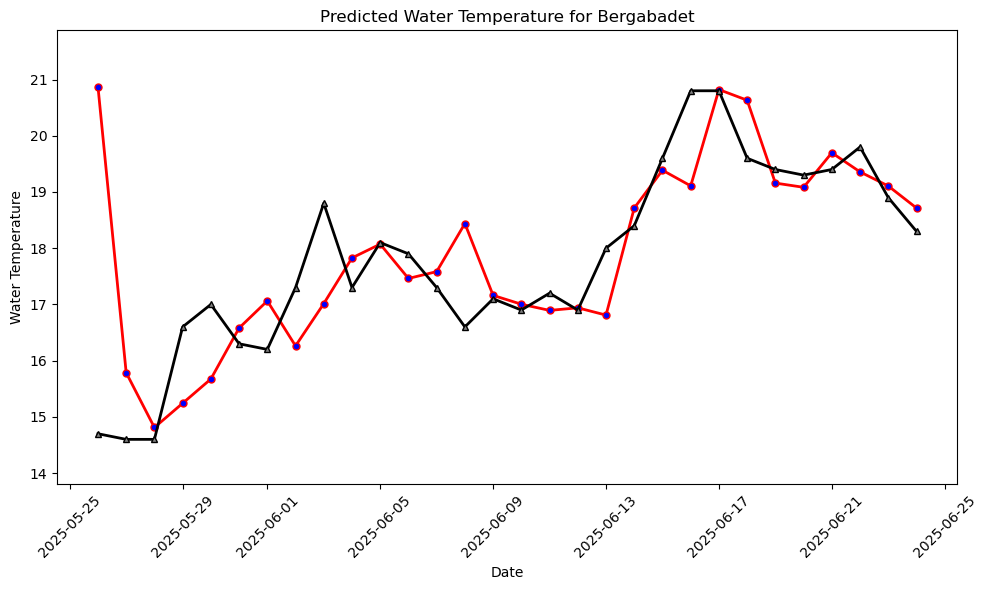

Bränningestrand
No data for: Bränningestrand
Eklundsnäsbadet


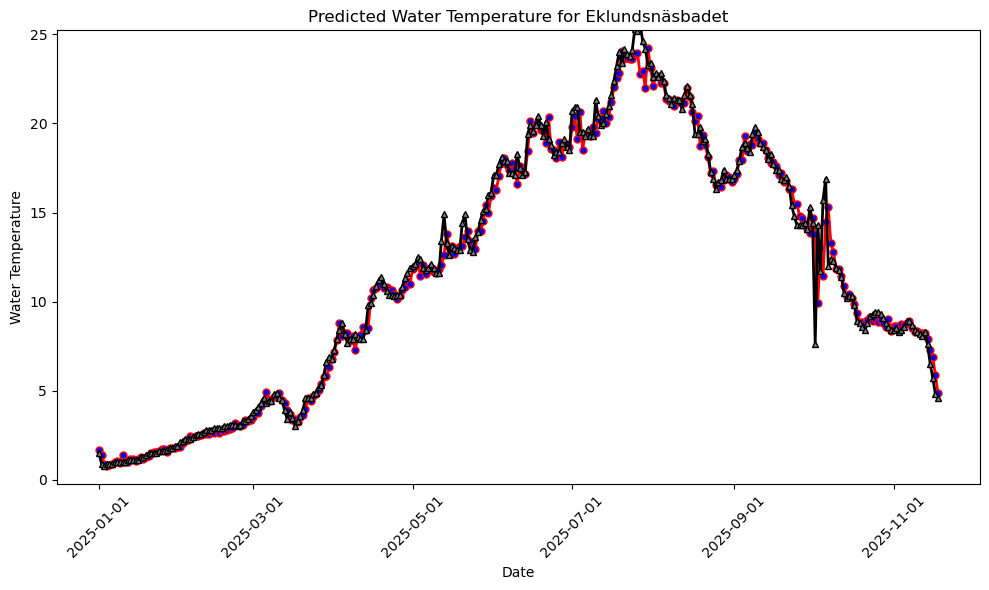

Farstanäsbadet


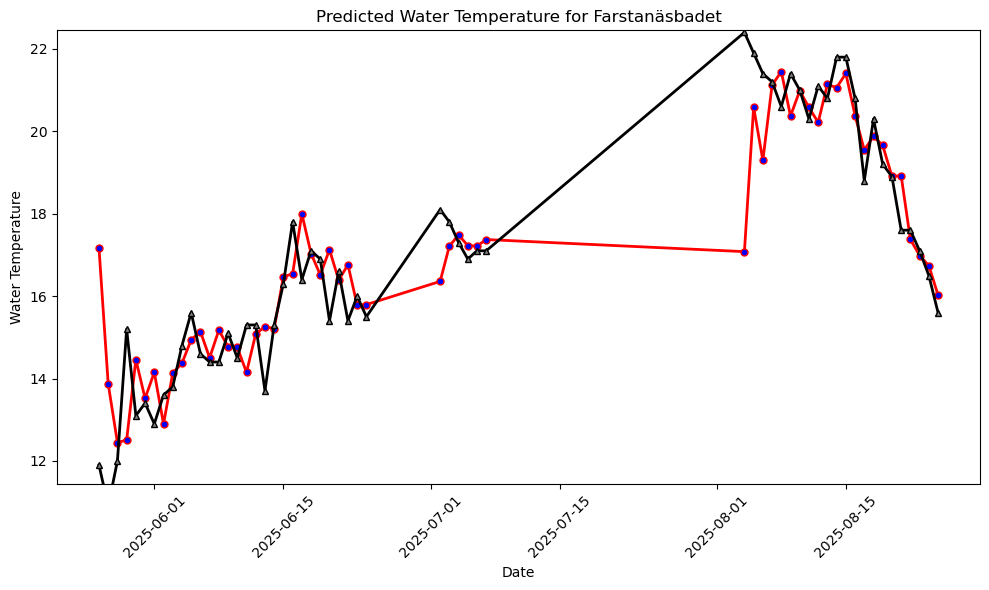

Mälarbadet


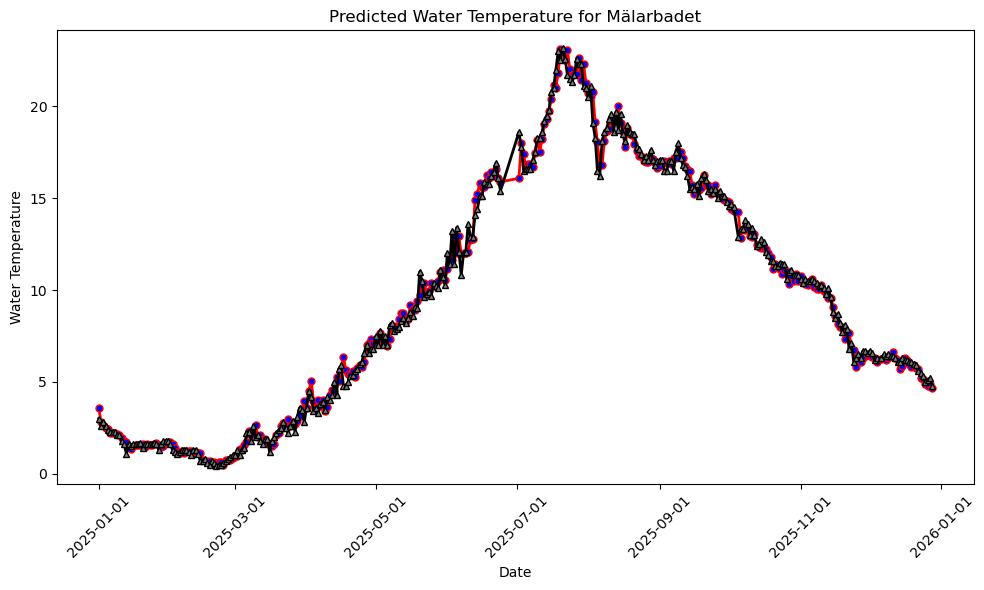

Nya Malmsjöbadet
No data for: Nya Malmsjöbadet
Näsets udde(Glashyttan)


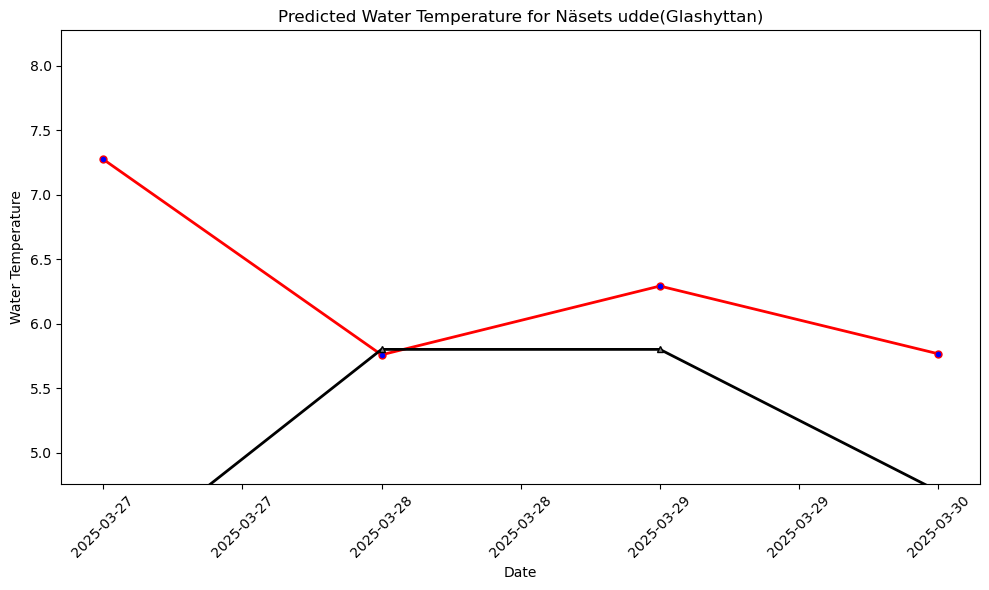

Underåsbadet
No data for: Underåsbadet
Åbynäsbadet


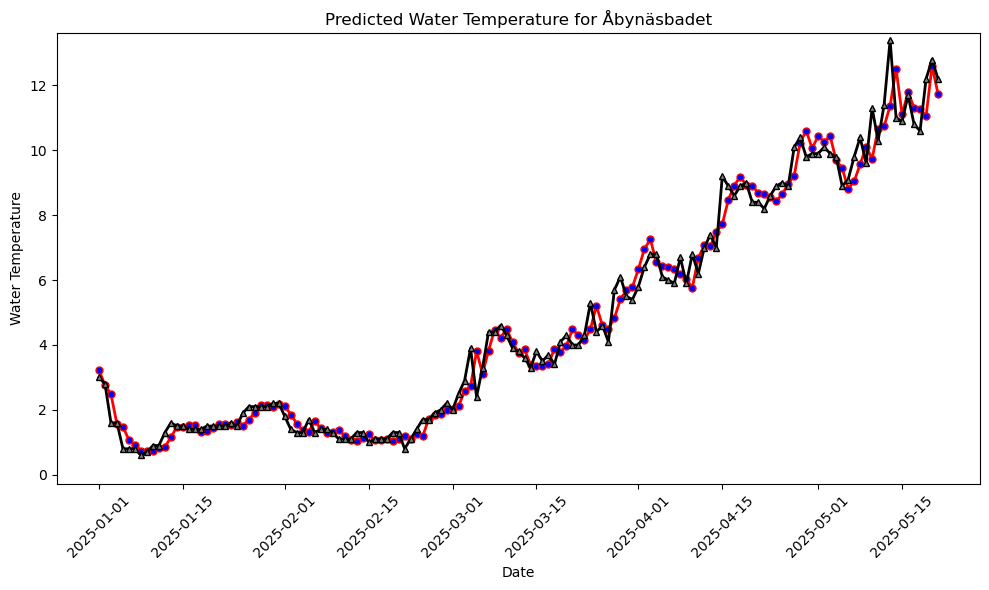

In [16]:
file_path = images_dir + "/water_temp_hindcast.png"

for location_dict in bath_locations:
    bath_location = location_dict["bath_location"]
    print(bath_location)

    file_path = images_dir + "/water_temp_hindcast" + str(bath_location) + ".png"

    location_df = df[df["alias"] == bath_location]

    if location_df.empty:
        print("No data for:", bath_location)
        continue

    plt = util.plot_water_temp_forecast(bath_location, location_df, str(file_path), hindcast=True) 
    plt.show()


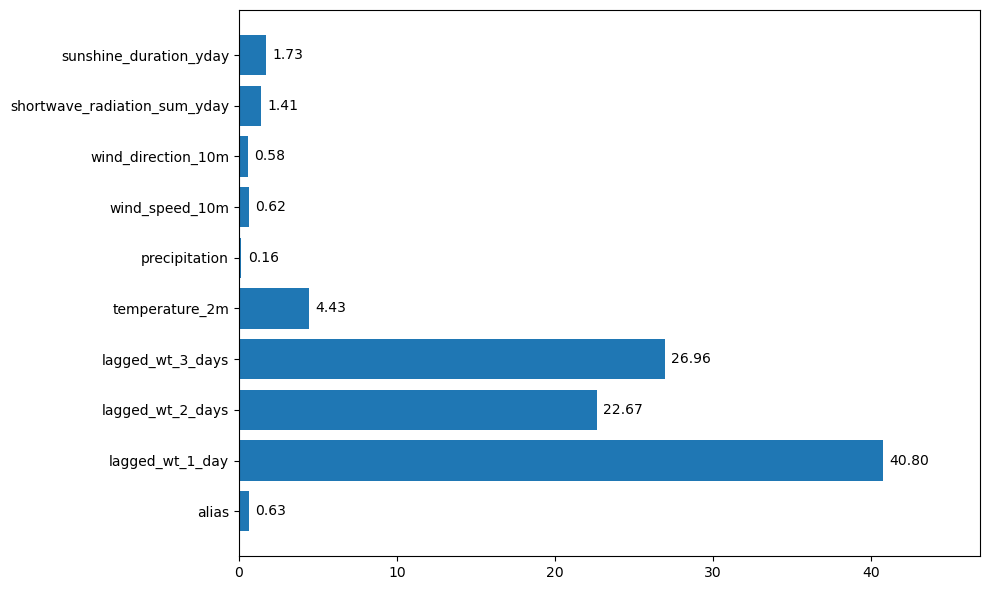

In [17]:
# Plotting feature importances using the plot_importance function from XGBoost

#plot_importance(xgb_regressor)
feature_importance = cat_regressor.get_feature_importance()
features = list(X_features.columns)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(features, feature_importance)

# add value on each bar
maxv = max(feature_importance) if len(feature_importance) else 0
ax.set_xlim(0, maxv * 1.15)  # extra space for labels

for bar, v in zip(bars, feature_importance):
    ax.text(
        bar.get_width() + maxv * 0.01,
        bar.get_y() + bar.get_height()/2,
        f"{v:.2f}",
        va="center", ha="left"
    )

plt.tight_layout()
plt.savefig(images_dir + "/feature_importance.png", dpi=200, bbox_inches="tight")
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [21]:
# Saving the regressor object as a json file in the model directory
#xgb_regressor.save_model(model_dir + "/model.json")
cat_regressor.save_model(model_dir + "/model.cbm")

In [22]:

 
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [23]:
mr = project.get_model_registry()

# Save model

wt_model = mr.python.create_model(
    #name="water_temperature_xgboost_model", 
    name="water_temperature_catboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Water Temperature Predictor",
)
wt_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Uploading /Users/kevinkokalari/Documents/Skalbar Maskininlärning och Djupinlärning/Laborationer/id2223-proje…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286295/models/water_temperature_catboost_model/3


Model(name: 'water_temperature_catboost_model', version: 3)